In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.cm as cm

## 1 Cross-correlation of the cued and uncued tags

### 1.1 Pre-post on cued

In [2]:
participants = ['A0', 'A1', 'A2'] 
crosscorr = []
for participant in participants:
    df_participant = pd.read_csv(f'files/{participant}_crosscor_prepost.csv', index_col=False)
    df_participant['participant'] = participant
    crosscorr.append(df_participant)
crosscorr = pd.concat(crosscorr)
crosscorr['Max crosscorrelation'] = crosscorr['value']
#averaging over electrodes
crosscorr = crosscorr.groupby(['participant','cued','prepost']).mean().reset_index()
crosscorr['Cueing'] = crosscorr['cued']
crosscorr['Cueing'] = crosscorr['cued'].replace({'cued': 'Cued', 'uncued': 'Uncued'})
crosscorr['Pre/post tag display'] = crosscorr['prepost'].replace({'pre': 'Pre-tag', 'post': 'Post-tag'})



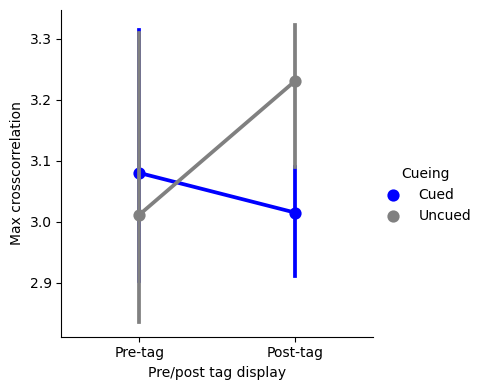

In [3]:
sns.catplot(y='Max crosscorrelation', x='Pre/post tag display', hue='Cueing', data=crosscorr, kind='point', order=['Pre-tag','Post-tag'], palette=['blue','grey'], height=4)

In [4]:
crosscorr.loc[crosscorr['prepost'] == 'pre', 'prepost'] = 0
crosscorr.loc[crosscorr['prepost'] == 'post', 'prepost'] = 1
crosscorr.loc[crosscorr['cued'] == 'uncued', 'cued'] = 0
crosscorr.loc[crosscorr['cued'] == 'cued', 'cued'] = 1
print(crosscorr)

   participant cued prepost     value  Max crosscorrelation  Cueing  \
0           A0    1       1  3.090493              3.090493    Cued   
1           A0    1       0  2.903955              2.903955    Cued   
2           A0    0       1  3.089554              3.089554  Uncued   
3           A0    0       0  2.836120              2.836120  Uncued   
4           A1    1       1  3.043976              3.043976    Cued   
5           A1    1       0  3.023019              3.023019    Cued   
6           A1    0       1  3.280434              3.280434  Uncued   
7           A1    0       0  3.309926              3.309926  Uncued   
8           A2    1       1  2.911419              2.911419    Cued   
9           A2    1       0  3.314114              3.314114    Cued   
10          A2    0       1  3.323133              3.323133  Uncued   
11          A2    0       0  2.889137              2.889137  Uncued   

   Pre/post tag display  
0              Post-tag  
1               Pre-tag 

In [5]:
md = smf.mixedlm("value ~ cued * prepost", crosscorr, groups=crosscorr["participant"])
mdf = md.fit()
print(mdf.summary())

              Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     value  
No. Observations:     12          Method:                 REML   
No. Groups:           3           Scale:                  0.0334 
Min. group size:      4           Log-Likelihood:         -0.0219
Max. group size:      4           Converged:              Yes    
Mean group size:      4.0                                        
-----------------------------------------------------------------
                       Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept               3.012    0.106 28.288 0.000  2.803  3.220
cued[T.1]               0.069    0.149  0.460 0.646 -0.224  0.361
prepost[T.1]            0.219    0.149  1.470 0.142 -0.073  0.512
cued[T.1]:prepost[T.1] -0.284    0.211 -1.348 0.178 -0.698  0.129
Group Var               0.001    0.057                           



/home/lea/anaconda3/envs/ads_thesis/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


### 1.2 Comparing same vs other trials

In [6]:
participants = ['A0', 'A1', 'A2'] 
crosscorr = []
for participant in participants:
    df_participant = pd.read_csv(f'files/{participant}_crosscor_sameother_cueduncued.csv', index_col=False)
    df_participant['participant'] = participant
    crosscorr.append(df_participant)
crosscorr = pd.concat(crosscorr)

crosscorr['Max crosscorrelation'] = crosscorr['value']
#averaging over electrodes
crosscorr = crosscorr.groupby(['participant','cued','trial_type']).mean().reset_index()
crosscorr['Cueing'] = crosscorr['cued'].replace({'cued': 'Cued', 'uncued': 'Uncued'})
crosscorr['Trial type'] = crosscorr['trial_type'].replace({'same': 'Same trials', 'other': 'Other trials'})



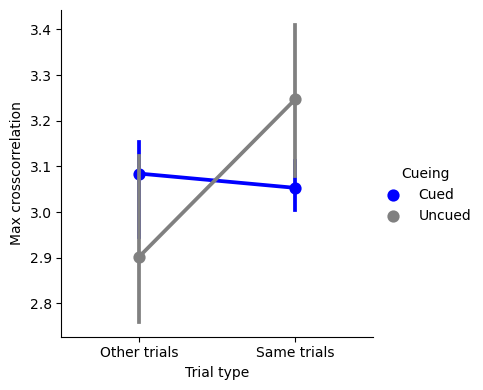

In [7]:
sns.catplot(y='Max crosscorrelation', x='Trial type', hue='Cueing', data=crosscorr, kind='point', units='participant', palette=['blue','grey'],  height=4)

In [8]:
crosscorr.loc[crosscorr['trial_type'] == 'same', 'trial_type'] = 0
crosscorr.loc[crosscorr['trial_type'] == 'other', 'trial_type'] = 1
crosscorr.loc[crosscorr['cued'] == 'uncued', 'cued'] = 0
crosscorr.loc[crosscorr['cued'] == 'cued', 'cued'] = 1
print(crosscorr)

   participant cued trial_type     value  Max crosscorrelation  Cueing  \
0           A0    1          1  2.945446              2.945446    Cued   
1           A0    1          0  3.004530              3.004530    Cued   
2           A0    0          1  2.759659              2.759659  Uncued   
3           A0    0          0  3.080123              3.080123  Uncued   
4           A1    1          1  3.153704              3.153704    Cued   
5           A1    1          0  3.112719              3.112719    Cued   
6           A1    0          1  3.123408              3.123408  Uncued   
7           A1    0          0  3.249841              3.249841  Uncued   
8           A2    1          1  3.154264              3.154264    Cued   
9           A2    1          0  3.042401              3.042401    Cued   
10          A2    0          1  2.824691              2.824691  Uncued   
11          A2    0          0  3.410172              3.410172  Uncued   

      Trial type  
0   Other trials  

In [9]:
md = smf.mixedlm("value ~ cued * trial_type", crosscorr, groups=crosscorr["participant"], missing='drop')
mdf = md.fit()
print(mdf.summary())

               Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      value 
No. Observations:       12           Method:                  REML  
No. Groups:             3            Scale:                   0.0111
Min. group size:        4            Log-Likelihood:          2.9670
Max. group size:        4            Converged:               Yes   
Mean group size:        4.0                                         
--------------------------------------------------------------------
                          Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------
Intercept                  3.247    0.083 39.185 0.000  3.084  3.409
cued[T.1]                 -0.193    0.086 -2.249 0.025 -0.362 -0.025
trial_type[T.1]           -0.344    0.086 -3.999 0.000 -0.513 -0.175
cued[T.1]:trial_type[T.1]  0.375    0.122  3.085 0.002  0.137  0.614
Group Var                  0.009    0.134         

/home/lea/anaconda3/envs/ads_thesis/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


## 2 Cross-correlation of the averaged tags 

### 2.1 Pre-post on averaged

In [10]:
participants = ['A0', 'A2'] 
crosscorr = []
for participant in participants:
    df_participant = pd.read_csv(f'files/{participant}_crosscor_prepost_avgtag.csv', index_col=False)
    df_participant['Participant'] = participant
    crosscorr.append(df_participant)
crosscorr = pd.concat(crosscorr)
crosscorr['Max crosscorrelation'] = crosscorr['value']
crosscorr['Pre/post tag display'] = crosscorr['prepost'].replace({'pre': 'Pre-tag', 'post': 'Post-tag'})


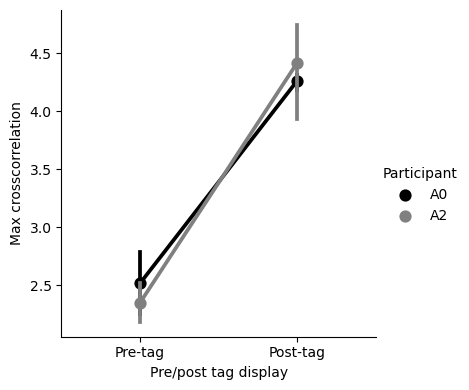

In [11]:
sns.catplot(y='Max crosscorrelation', x='Pre/post tag display', hue='Participant', data=crosscorr, kind='point',  palette=['black','grey'], height=4, order=['Pre-tag', 'Post-tag'])

In [12]:
crosscorr.loc[crosscorr['prepost'] == 'pre', 'prepost'] = 0
crosscorr.loc[crosscorr['prepost'] == 'post', 'prepost'] = 1
print(crosscorr)

      value prepost Participant  Max crosscorrelation Pre/post tag display
0  2.481740       0          A0              2.481740              Pre-tag
1  2.617967       0          A0              2.617967              Pre-tag
2  2.124736       0          A0              2.124736              Pre-tag
3  2.841421       0          A0              2.841421              Pre-tag
4  4.150722       1          A0              4.150722             Post-tag
5  4.282637       1          A0              4.282637             Post-tag
6  4.327177       1          A0              4.327177             Post-tag
7  4.295897       1          A0              4.295897             Post-tag
0  2.523402       0          A2              2.523402              Pre-tag
1  2.339511       0          A2              2.339511              Pre-tag
2  2.184126       0          A2              2.184126              Pre-tag
3  4.745633       1          A2              4.745633             Post-tag
4  3.931602       1      

In [13]:
md = smf.mixedlm("value ~ prepost", crosscorr, groups=crosscorr["Participant"])
mdf = md.fit()
print(mdf.summary())

        Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: value  
No. Observations:  14      Method:             REML   
No. Groups:        2       Scale:              0.0672 
Min. group size:   6       Log-Likelihood:     -2.7720
Max. group size:   8       Converged:          Yes    
Mean group size:   7.0                                
------------------------------------------------------
             Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    2.445    0.098 24.953 0.000  2.253  2.637
prepost[T.1] 1.886    0.139 13.611 0.000  1.614  2.158
Group Var    0.000                                    



/home/lea/anaconda3/envs/ads_thesis/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:1635: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/lea/anaconda3/envs/ads_thesis/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:1635: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/lea/anaconda3/envs/ads_thesis/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/lea/anaconda3/envs/ads_thesis/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2262: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


### 2.2 Comparing same vs other trials

In [14]:
participants = ['A0', 'A2'] 
crosscorr = []
for participant in participants:
    df_participant = pd.read_csv(f'files/{participant}_crosscor_sameother_averaged.csv', index_col=False)
    df_participant['Participant'] = participant
    crosscorr.append(df_participant)
crosscorr = pd.concat(crosscorr)

crosscorr['Max crosscorrelation'] = crosscorr['value']
#averaging over electrodes
# crosscorr = crosscorr.groupby(['participant','trial_type']).mean().reset_index()
crosscorr['Trial type'] = crosscorr['trial_type'].replace({'same': 'Same trials', 'other': 'Other trials'})


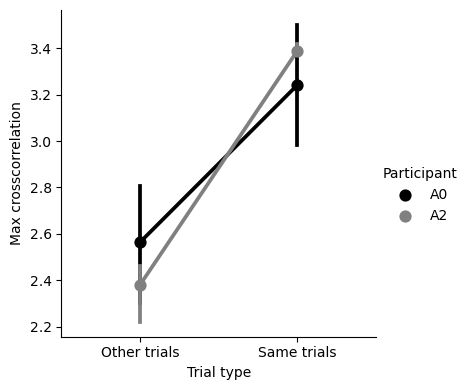

In [15]:
sns.catplot(y='Max crosscorrelation', x='Trial type', hue='Participant', data=crosscorr, kind='point',  palette=['black','grey'], height=4, order=['Other trials', 'Same trials'])

In [16]:
crosscorr.loc[crosscorr['trial_type'] == 'same', 'trial_type'] = 0
crosscorr.loc[crosscorr['trial_type'] == 'other', 'trial_type'] = 1
print(crosscorr)

      value trial_type Participant  Max crosscorrelation    Trial type
0  2.967925          0          A0              2.967925   Same trials
1  2.996832          0          A0              2.996832   Same trials
2  3.440798          0          A0              3.440798   Same trials
3  3.560001          0          A0              3.560001   Same trials
4  2.811334          1          A0              2.811334  Other trials
5  2.284699          1          A0              2.284699  Other trials
6  2.360643          1          A0              2.360643  Other trials
7  2.799311          1          A0              2.799311  Other trials
0  3.416612          0          A2              3.416612   Same trials
1  3.376801          0          A2              3.376801   Same trials
2  3.372993          0          A2              3.372993   Same trials
3  2.461505          1          A2              2.461505  Other trials
4  2.220704          1          A2              2.220704  Other trials
5  2.4

In [17]:
md = smf.mixedlm("value ~ trial_type", crosscorr, groups=crosscorr["Participant"], missing='drop')
mdf = md.fit()
print(mdf.summary())

          Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  value  
No. Observations:    14       Method:              REML   
No. Groups:          2        Scale:               0.0539 
Min. group size:     6        Log-Likelihood:      -1.4445
Max. group size:     8        Converged:           Yes    
Mean group size:     7.0                                  
----------------------------------------------------------
                Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------
Intercept        3.305    0.088 37.683 0.000  3.133  3.476
trial_type[T.1] -0.819    0.124 -6.605 0.000 -1.062 -0.576
Group Var        0.000                                    



/home/lea/anaconda3/envs/ads_thesis/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:1635: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/lea/anaconda3/envs/ads_thesis/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/lea/anaconda3/envs/ads_thesis/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2262: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


## 3 Search in subwindows of the tag

In [18]:
from noise_tagging_funs import generate_noise_periods

sfreq = 480 # EEG and tag tmin_eeg, tmax_eeg = 0, epochs_noistag.tmax
lag = .1
tmax_eeg = 2.3

# Define period of noise to analyze
start = 0
duration = .4
step = .1
end = tmax_eeg-lag
# Create a list of tag segments of duration 400ms with a step of 100ms
noise_periods = generate_noise_periods(start, end, duration, step)[::-1]

# EEG segments studied
n_bins = 45
time_bins = np.linspace(start, tmax_eeg-duration, n_bins+1)*sfreq


### 3.1  Timing of the crosscorrelation with the average of the two tags

In [19]:
participants = ['A0', 'A2'] 
summed = []
for participant in participants:
    arr_participant = np.load(f'files/averaged_tags_{participant}.npy')
    summed.append(arr_participant)
summed = np.stack(summed)

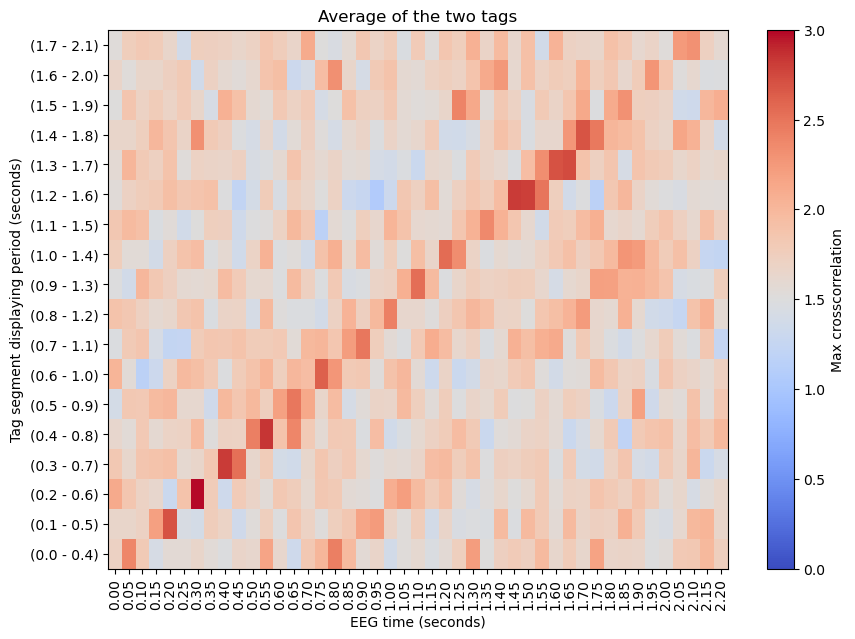

In [20]:
fig, ax = plt.subplots(figsize=(10,7))
avg_summed = summed.mean(axis=0)
cax = ax.imshow(avg_summed, aspect='auto', cmap='coolwarm', interpolation='nearest', vmin=0, vmax=3)

cbar = fig.colorbar(cax)
cbar.set_label('Max crosscorrelation')

ax.set_xlabel('EEG time (seconds)')
ax.set_ylabel('Tag segment displaying period (seconds)')
ax.set_title('Average of the two tags')

bin_times = np.linspace(start, end, n_bins)
ax.set_xticks(np.arange(n_bins))
ax.set_xticklabels([f'{bt:.2f}' for bt in bin_times], rotation=90)
ax.set_yticks(np.arange(len(noise_periods)))
ax.set_yticklabels([f'({i[0]:.1f} - {i[1]:.1f})' for i in noise_periods])


plt.show()


In [21]:
idx_noise_periods, idx_bin_times = np.where(summed.mean(axis=0) > 2.6)
for period, bin in zip(idx_noise_periods, idx_bin_times):
    print(f'Significant for noise : {np.array(noise_periods)[period]} and bin {np.array(bin_times)[bin]:.2f} (zscore = {summed.mean(axis=0)[period, bin]})')

Significant for noise : [1.4 1.8] and bin 1.70 (zscore = 2.684858054051599)
Significant for noise : [1.3 1.7] and bin 1.60 (zscore = 2.6984152223505142)
Significant for noise : [1.3 1.7] and bin 1.65 (zscore = 2.7346233671342652)
Significant for noise : [1.2 1.6] and bin 1.45 (zscore = 2.8145091910870597)
Significant for noise : [1.2 1.6] and bin 1.50 (zscore = 2.7947081409278205)
Significant for noise : [0.6 1. ] and bin 0.75 (zscore = 2.621573499959303)
Significant for noise : [0.4 0.8] and bin 0.55 (zscore = 2.8466276462404165)
Significant for noise : [0.3 0.7] and bin 0.40 (zscore = 2.8153152302392224)
Significant for noise : [0.2 0.6] and bin 0.30 (zscore = 2.9861149113188503)
Significant for noise : [0.1 0.5] and bin 0.20 (zscore = 2.696830966648534)


### 3.2 Timing of the crosscorrelation with each of the tags (cueing effect)

In [22]:
participants = ['A0', 'A2'] 
cued, uncued = [], []
for participant in participants:
    arr_participant = np.load(f'files/cued_tags_with_target_{participant}.npy')
    cued.append(arr_participant)
    arr_participant = np.load(f'files/uncued_tags_with_target_{participant}.npy')
    uncued.append(arr_participant)
cued = np.stack(cued)
uncued = np.stack(uncued)

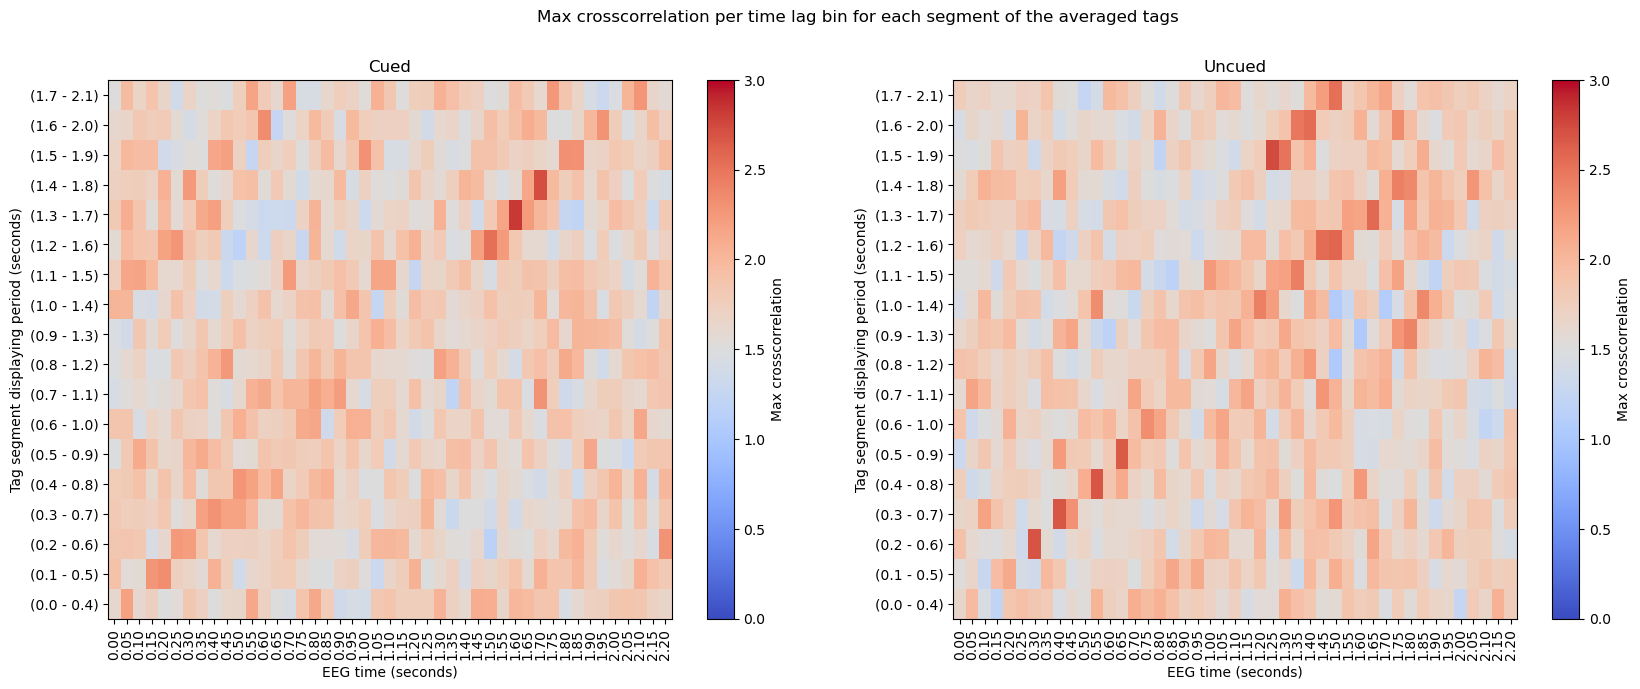

In [23]:
fig, ax = plt.subplots(1,2, figsize=(20,7), sharey=False)
cax = ax[0].imshow(cued.mean(axis=0), aspect='auto', cmap='coolwarm', interpolation='nearest', vmin=0, vmax=3)
cbar = fig.colorbar(cax)
cbar.set_label('Max crosscorrelation')
cax = ax[1].imshow(uncued.mean(axis=0), aspect='auto', cmap='coolwarm', interpolation='nearest', vmin=0, vmax=3)
cbar = fig.colorbar(cax)
cbar.set_label('Max crosscorrelation')

plt.suptitle('Max crosscorrelation per time lag bin for each segment of the averaged tags')

threshold = 1.96
bin_times = np.linspace(start, end, n_bins)
for i, axi in enumerate(ax):
    axi.set_xticks(np.arange(n_bins))
    axi.set_xticklabels([f'{bt:.2f}' for bt in bin_times], rotation=90)
    axi.set_yticks(np.arange(len(noise_periods)))
    axi.set_yticklabels([f'({i[0]:.1f} - {i[1]:.1f})' for i in noise_periods])
    axi.set_xlabel('EEG time (seconds)')
    axi.set_ylabel('Tag segment displaying period (seconds)')

ax[0].set_title('Cued')
ax[1].set_title('Uncued')
plt.show()
plt.show()

In [24]:
idx_noise_periods, idx_bin_times = np.where(cued.mean(axis=0) > 2.6)
for period, bin in zip(idx_noise_periods, idx_bin_times):
    print(f'[Cued] Significant for noise : {np.array(noise_periods)[period]} and bin {np.array(bin_times)[bin]:.2f}  (zscore = {cued.mean(axis=0)[period, bin]})')

[Cued] Significant for noise : [1.4 1.8] and bin 1.70  (zscore = 2.724445605211586)
[Cued] Significant for noise : [1.3 1.7] and bin 1.60  (zscore = 2.8349921960834132)


In [25]:
idx_noise_periods, idx_bin_times = np.where(uncued.mean(axis=0) > 2.6)
for period, bin in zip(idx_noise_periods, idx_bin_times):
    print(f'[Uncued] Significant for noise : {np.array(noise_periods)[period]} and bin {np.array(bin_times)[bin]:.2f}  (zscore = {uncued.mean(axis=0)[period, bin]})')

[Uncued] Significant for noise : [1.5 1.9] and bin 1.25  (zscore = 2.7374911255630274)
[Uncued] Significant for noise : [0.5 0.9] and bin 0.65  (zscore = 2.650379789744911)
[Uncued] Significant for noise : [0.4 0.8] and bin 0.55  (zscore = 2.673958755686992)
[Uncued] Significant for noise : [0.3 0.7] and bin 0.40  (zscore = 2.681238253735131)
[Uncued] Significant for noise : [0.2 0.6] and bin 0.30  (zscore = 2.6864900595163315)
